### Loading Libraries and Data

In [1]:
import os
os.chdir("../")
%pwd

'c:\\Users\\HP\\Desktop\\ML\\Customer_Churn_Predictor'

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import optuna

In [4]:
df = pd.read_csv("artifacts/data_ingestion/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### Understanding Data

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The data set includes information about:

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information - how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependents

In [6]:
df.shape

(7043, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

### Visualising Missing Values

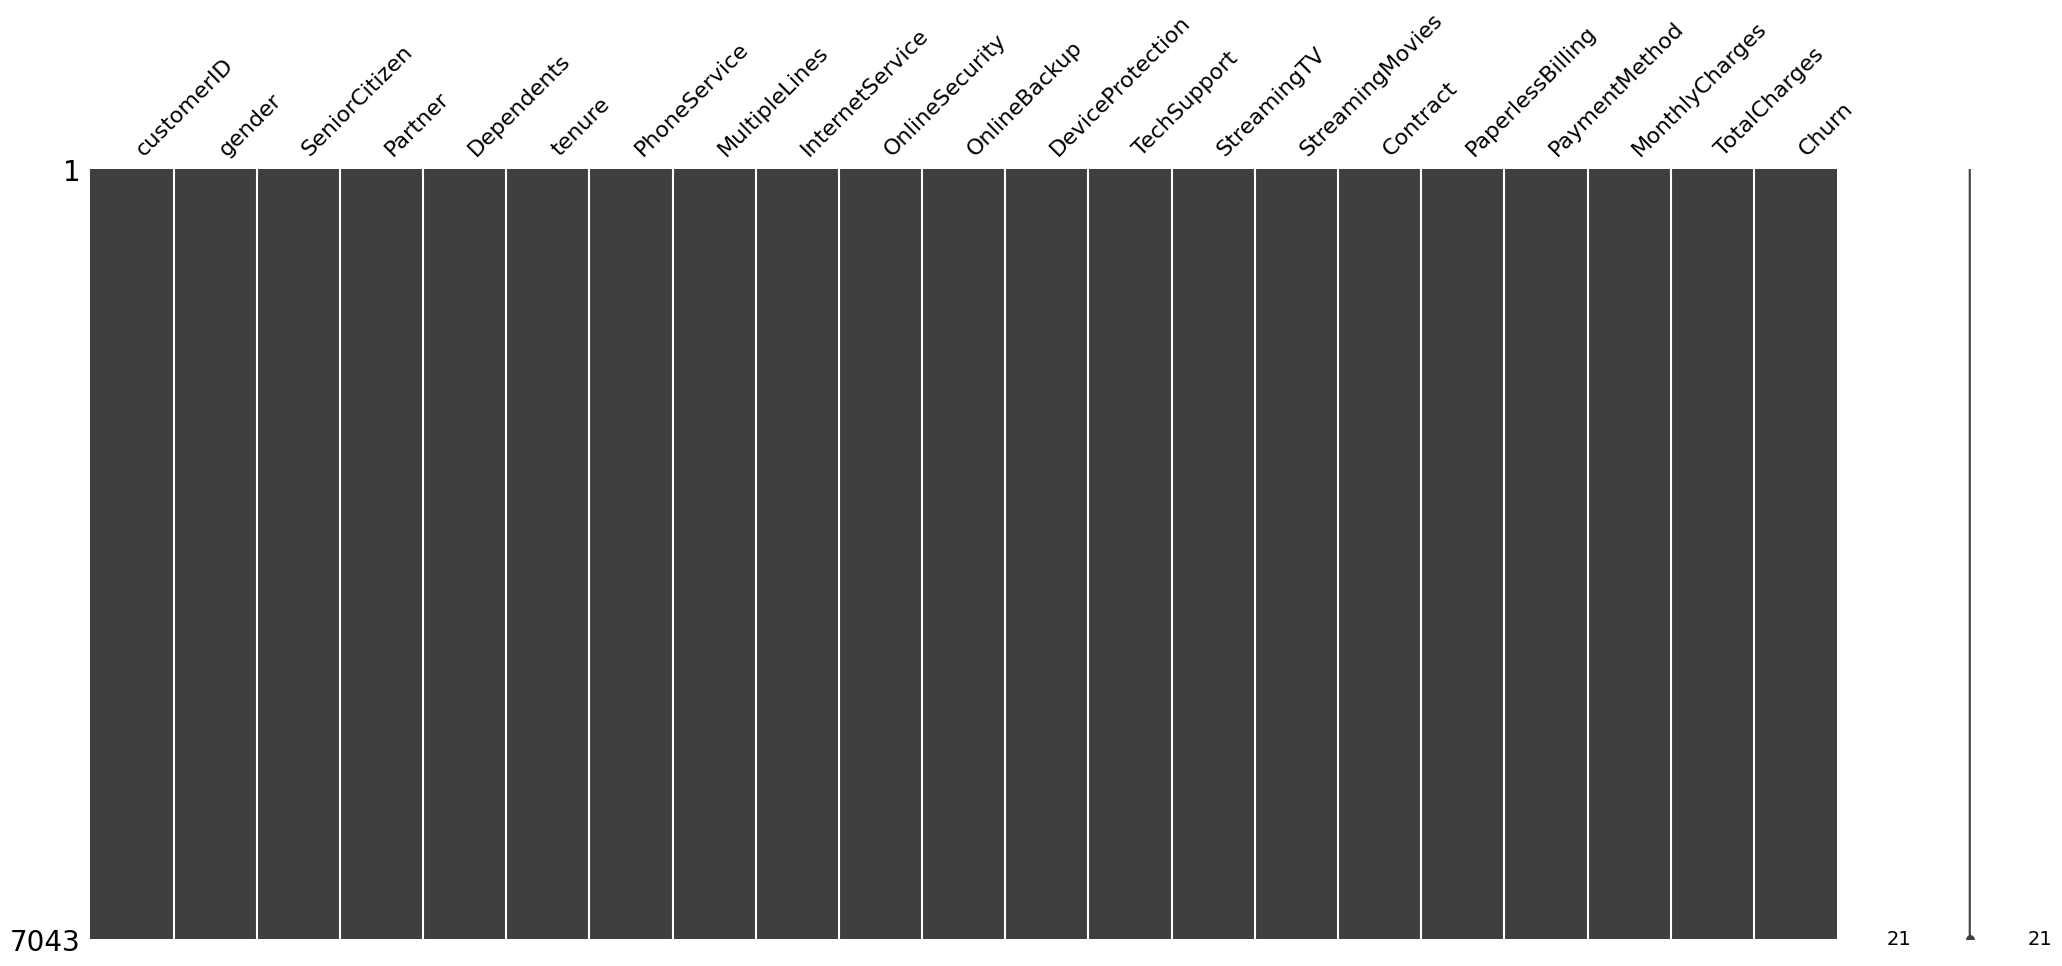

In [9]:
msno.matrix(df);

From the above visualisation we can observe that it has no peculiar pattern that stands out. In fact there is no missing data.

### Data Manipulation

In [10]:
df = df.drop(['customerID'], axis = 1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
#TotalCharges column has dtype as object so we will convert it to numeric and if it is not convertible we will set them as NaN
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


It can also be noted that the Tenure column is 0 for these entries even though the MonthlyCharges column is not empty.

In [13]:
df[df['tenure'] == 0].index

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

Since there are only 11 rows with missing values of tenure we will delete them

In [14]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)

In [15]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [16]:
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


### Data Visualisation

In [18]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),
              1, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

26.6 % of customers switched to another firm.
Customers are 49.5 % female and 50.5 % male.

In [19]:
df["Churn"][df["Churn"]=="No"].groupby(by=df["gender"]).count()

gender
Female    2544
Male      2619
Name: Churn, dtype: int64

In [20]:
df["Churn"][df["Churn"]=="Yes"].groupby(by=df["gender"]).count()

gender
Female    939
Male      930
Name: Churn, dtype: int64

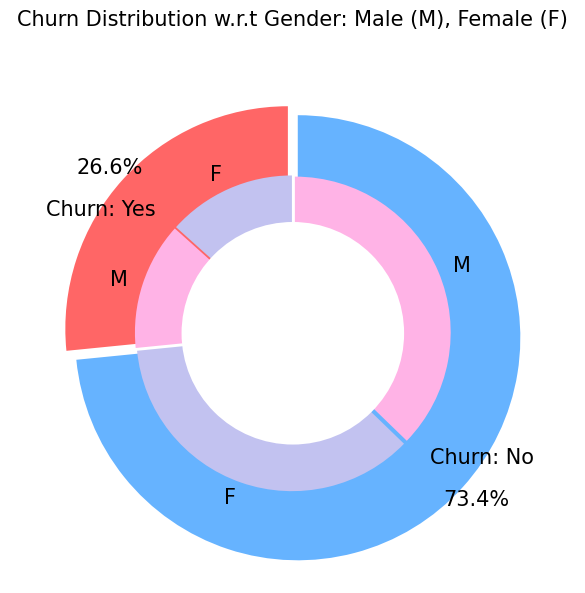

In [21]:
import matplotlib.pyplot as plt

# Data
labels = ["Churn: Yes", "Churn: No"]
values = [1869, 5163]
labels_gender = ["F", "M", "F", "M"]
sizes_gender = [939, 930, 2544, 2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0', '#ffb3e6', '#c2c2f0', '#ffb3e6']
explode = (0.3, 0.3)
explode_gender = (0.1, 0.1, 0.1, 0.1)
textprops = {"fontsize": 15}

# Plot
plt.figure(figsize=(6, 6))

# Main pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08, 
        labeldistance=0.8, colors=colors, startangle=90, frame=True, 
        explode=explode, radius=10, textprops=textprops, counterclock=True)

# Inner pie chart for gender distribution
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, 
        startangle=90, explode=explode_gender, radius=7, 
        textprops=textprops, counterclock=True)

# Draw center circle to create a donut chart effect
centre_circle = plt.Circle((0, 0), 5, color='black', fc='white', linewidth=0)
plt.gca().add_artist(centre_circle)

# Title and layout
plt.title('Churn Distribution w.r.t Gender: Male (M), Female (F)', fontsize=15, y=1.1)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [22]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

In [23]:
# Create a 2x5 subplot figure
fig = make_subplots(rows=4, cols=2, subplot_titles=[
    "Customer Contract Distribution",
    "Customer Payment Method Distribution w.r.t. Churn",
    "Dependents Distribution",
    "Churn Distribution w.r.t. Partners",
    "Churn Distribution w.r.t. Senior Citizen",
    "Churn w.r.t Online Security",
    "Churn Distribution w.r.t. Phone Service",
    "Churn Distribution w.r.t. Paperless Billing"],
    vertical_spacing=0.05)

# Plot 1: Customer Contract Distribution
hist1 = px.histogram(df, x="Churn", color="Contract", barmode="group").data[0]
hist2 = px.histogram(df, x="Churn", color="Contract", barmode="group").data[1]
fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=1)

# Plot 2: Customer Payment Method Distribution w.r.t. Churn
for trace in px.histogram(df, x="Churn", color="PaymentMethod").data:
    fig.add_trace(trace, row=1, col=2)

# Plot 3: Dependents Distribution
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
for trace in px.histogram(df, x="Churn", color="Dependents", barmode="group", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=2, col=1)

# Plot 4: Churn Distribution w.r.t. Partners
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
for trace in px.histogram(df, x="Churn", color="Partner", barmode="group", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=2, col=2)

# Plot 5: Churn Distribution w.r.t. Senior Citizen
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
for trace in px.histogram(df, x="Churn", color="SeniorCitizen", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=3, col=1)

# Plot 6: Churn w.r.t Online Security
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
for trace in px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=3, col=2)

# Plot 7: Churn Distribution w.r.t. Phone Service
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
for trace in px.histogram(df, x="Churn", color="PhoneService", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=4, col=1)

# Plot 8: Churn Distribution w.r.t. Paperless Billing
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
for trace in px.histogram(df, x="Churn", color="PaperlessBilling", color_discrete_map=color_map).data:
    fig.add_trace(trace, row=4, col=2)

# Update layout
fig.update_layout(height=2000, width=1000, title_text="Customer Churn Analysis with Multiple Features", title_x=0.5, showlegend=False, bargap=0.1)
fig.show()

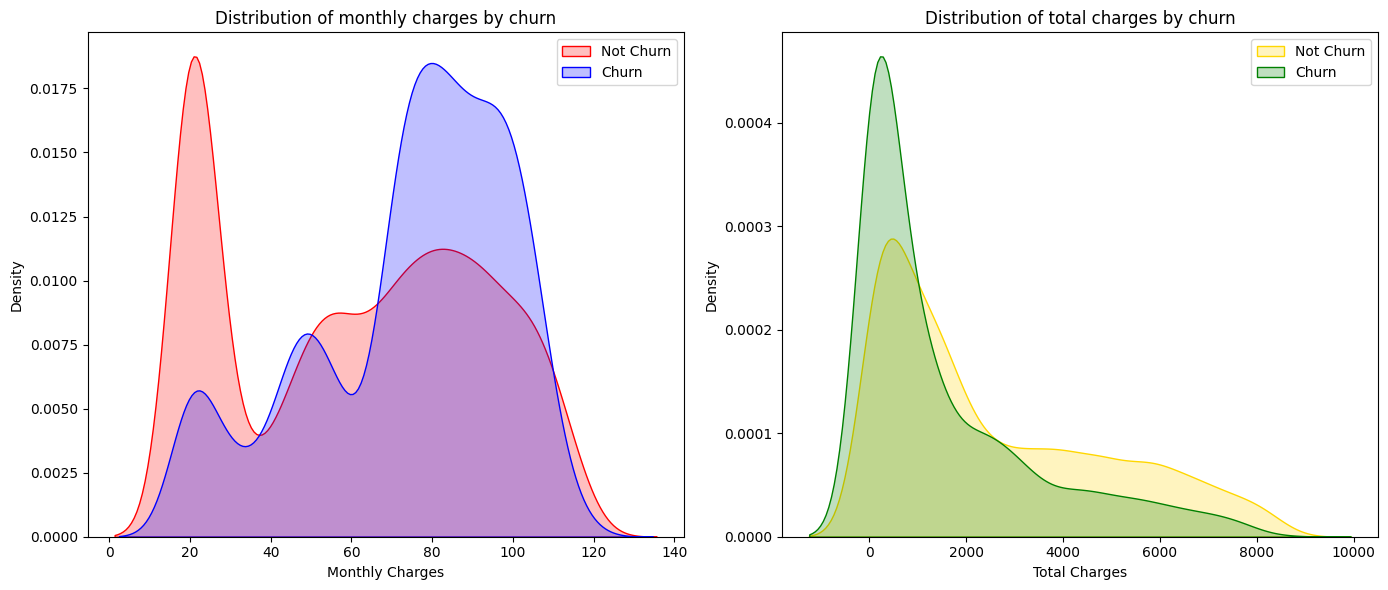

In [24]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Monthly Charges
sns.kdeplot(df.MonthlyCharges[df["Churn"] == 'No'], color="Red", shade=True, ax=axes[0])
sns.kdeplot(df.MonthlyCharges[df["Churn"] == 'Yes'], color="Blue", shade=True, ax=axes[0])
axes[0].legend(["Not Churn", "Churn"], loc='upper right')
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_title('Distribution of monthly charges by churn')

# Plot 2: Total Charges
sns.kdeplot(df.TotalCharges[df["Churn"] == 'No'], color="Gold", shade=True, ax=axes[1])
sns.kdeplot(df.TotalCharges[df["Churn"] == 'Yes'], color="Green", shade=True, ax=axes[1])
axes[1].legend(["Not Churn", "Churn"], loc='upper right')
axes[1].set_ylabel('Density')
axes[1].set_xlabel('Total Charges')
axes[1].set_title('Distribution of total charges by churn')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Data Preprocessing

In [25]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [26]:
df = df.apply(lambda x: object_to_int(x))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [27]:
plt.figure(figsize=(14,7))
df.corr()['Churn'].sort_values(ascending = False)

Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64

<Figure size 1400x700 with 0 Axes>

In [28]:
X = df.drop(columns = ['Churn'])
y = df['Churn'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

As dataset is imbalanced we will resample it.

In [30]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [31]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)

In [32]:
scaler= StandardScaler()

X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Machine Learning Model Evaluations and Predictions

1) KNN

In [33]:
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train_resampled,y_train_resampled)
y_pred = knn_model.predict(X_test)
print("KNN accuracy:",accuracy_score(y_test, y_pred))

KNN accuracy: 0.7279620853080568


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1549
           1       0.49      0.76      0.60       561

    accuracy                           0.73      2110
   macro avg       0.69      0.74      0.70      2110
weighted avg       0.79      0.73      0.74      2110



2) SVC

In [35]:
svc_model = SVC(random_state = 1)
svc_model.fit(X_train_resampled,y_train_resampled)
y_pred = svc_model.predict(X_test)
print("SVM accuracy is :",accuracy_score(y_test, y_pred))

SVM accuracy is : 0.7758293838862559


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1549
           1       0.57      0.68      0.62       561

    accuracy                           0.78      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.78      0.78      2110



3) Gradient Boosting Classifier

In [37]:
gb = GradientBoostingClassifier()
gb.fit(X_train_resampled, y_train_resampled)
y_pred = gb.predict(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, y_pred))

Gradient Boosting Classifier 0.7701421800947867


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1549
           1       0.55      0.72      0.63       561

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.80      0.77      0.78      2110



4) Decision Tree Classifier

In [39]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_resampled,y_train_resampled)
y_pred = dt_model.predict(X_test)
print("Decision Tree accuracy is :",accuracy_score(y_test, y_pred))

Decision Tree accuracy is : 0.7312796208530805


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1549
           1       0.50      0.59      0.54       561

    accuracy                           0.73      2110
   macro avg       0.67      0.69      0.67      2110
weighted avg       0.75      0.73      0.74      2110



5) Adaboost Classifier

In [41]:
a_model = AdaBoostClassifier()
a_model.fit(X_train_resampled,y_train_resampled)
y_pred = a_model.predict(X_test)
print("AdaBoost Classifier accuracy: ",accuracy_score(y_test, y_pred))

AdaBoost Classifier accuracy:  0.7592417061611374


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1549
           1       0.53      0.75      0.62       561

    accuracy                           0.76      2110
   macro avg       0.71      0.75      0.72      2110
weighted avg       0.80      0.76      0.77      2110



6) Catboost Classifier

In [43]:
c_model = CatBoostClassifier()
c_model.fit(X_train_resampled,y_train_resampled)
y_pred = c_model.predict(X_test)
print("CatBoost Classifier accuracy: ",accuracy_score(y_test, y_pred))

Learning rate set to 0.023974
0:	learn: 0.6792649	total: 136ms	remaining: 2m 16s
1:	learn: 0.6657969	total: 141ms	remaining: 1m 10s
2:	learn: 0.6524923	total: 145ms	remaining: 48.3s
3:	learn: 0.6421769	total: 149ms	remaining: 37.2s
4:	learn: 0.6320172	total: 154ms	remaining: 30.7s
5:	learn: 0.6215589	total: 158ms	remaining: 26.2s
6:	learn: 0.6123561	total: 164ms	remaining: 23.3s
7:	learn: 0.6032244	total: 169ms	remaining: 21s
8:	learn: 0.5953515	total: 173ms	remaining: 19.1s
9:	learn: 0.5861631	total: 178ms	remaining: 17.6s
10:	learn: 0.5773977	total: 183ms	remaining: 16.5s
11:	learn: 0.5691740	total: 188ms	remaining: 15.5s
12:	learn: 0.5622882	total: 193ms	remaining: 14.7s
13:	learn: 0.5557701	total: 199ms	remaining: 14s
14:	learn: 0.5493296	total: 205ms	remaining: 13.5s
15:	learn: 0.5429136	total: 212ms	remaining: 13s
16:	learn: 0.5370792	total: 217ms	remaining: 12.5s
17:	learn: 0.5316711	total: 263ms	remaining: 14.3s
18:	learn: 0.5261860	total: 272ms	remaining: 14s
19:	learn: 0.5215

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1549
           1       0.55      0.58      0.57       561

    accuracy                           0.76      2110
   macro avg       0.70      0.70      0.70      2110
weighted avg       0.77      0.76      0.77      2110



In [55]:
X_train_resampled.shape

(7228, 19)

In [56]:
y_train_resampled.shape

(7228,)

In [88]:
c_model = CatBoostClassifier(learning_rate = 0.05, l2_leaf_reg = 1, iterations = 2000, depth = 8, border_count = 128, bagging_temperature = 1, class_weights=[1, 2.78])
c_model.fit(X_train_resampled,y_train_resampled)
y_pred = c_model.predict(X_test)

0:	learn: 0.6627502	total: 4.72ms	remaining: 9.44s
1:	learn: 0.6336701	total: 12.6ms	remaining: 12.6s
2:	learn: 0.6001872	total: 16.7ms	remaining: 11.1s
3:	learn: 0.5722258	total: 21.3ms	remaining: 10.6s
4:	learn: 0.5468970	total: 27.3ms	remaining: 10.9s
5:	learn: 0.5256309	total: 31.7ms	remaining: 10.5s
6:	learn: 0.5025254	total: 36.2ms	remaining: 10.3s
7:	learn: 0.4838414	total: 39.8ms	remaining: 9.91s
8:	learn: 0.4666565	total: 43.4ms	remaining: 9.59s
9:	learn: 0.4534325	total: 46.9ms	remaining: 9.34s
10:	learn: 0.4394420	total: 50.5ms	remaining: 9.13s
11:	learn: 0.4289822	total: 54.3ms	remaining: 9s
12:	learn: 0.4187951	total: 58ms	remaining: 8.86s
13:	learn: 0.4099471	total: 61.6ms	remaining: 8.74s
14:	learn: 0.4017913	total: 65.4ms	remaining: 8.65s
15:	learn: 0.3941393	total: 69.9ms	remaining: 8.67s
16:	learn: 0.3866366	total: 73.6ms	remaining: 8.59s
17:	learn: 0.3796728	total: 77.7ms	remaining: 8.55s
18:	learn: 0.3728591	total: 81.9ms	remaining: 8.54s
19:	learn: 0.3670639	total:

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1549
           1       0.51      0.63      0.57       561

    accuracy                           0.74      2110
   macro avg       0.68      0.71      0.69      2110
weighted avg       0.76      0.74      0.75      2110



In [90]:
y_pred_proba = c_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1549
           1       0.50      0.68      0.58       561

    accuracy                           0.74      2110
   macro avg       0.68      0.72      0.69      2110
weighted avg       0.77      0.74      0.75      2110



Out of all algorithms Catboost is giving greater accuracy of 76.2% . So we will select it and perform hyperparameter tuning.

### Hyperparmeter Tuning

In [48]:
param_dist = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 2, 3],
    'border_count': [32, 64, 128]
}

In [49]:
catboost_model = CatBoostClassifier(random_seed=42, logging_level='Silent')
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=300,  
    cv=3,  
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [91]:
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


KeyboardInterrupt: 

In [ ]:
best_params = random_search.best_params_
print("Best Parameters:", best_params)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
catboost_model.set_params(**best_params)
catboost_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
y_pred = catboost_model.predict(X_test)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

In [ ]:
print("CatBoost Classifier Tuned Model Accuracy: ",accuracy_score(y_test, y_pred))

CatBoost Classifier Tuned Model Accuracy:  0.761611374407583
